# NBA Project
## Umer Ahmed
### In this project I used Data Science techniques to predict the winners between 2 teams in an NBA Game.


## Install libraries

In [23]:
%pip install nba_api

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Python39\python.exe -m pip install --upgrade pip' command.


## Import libraries

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nba_api.stats.endpoints import leaguegamefinder


## Load dataset

In [29]:
LAST_N_GAMES = 30
# get game data from the 2000s-present from nba_api 
gamefinder = leaguegamefinder.LeagueGameFinder(date_from_nullable='01/01/2000', league_id_nullable='00')
team_stats = gamefinder.get_data_frames()[0]
# Returned colums:
# [   'SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID', 
#     'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'PTS', 'FGM', 'FGA', 'FG_PCT',
#     'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB',
#     'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PLUS_MINUS' ]

# Filter columns that I believe are less important in at team winning or loosing 
team_stats = team_stats[['TEAM_NAME', 'GAME_ID', 'GAME_DATE','MATCHUP','WL','FG_PCT','FG3_PCT','FT_PCT', 'REB', 'AST', 'STL', 'BLK', 'TOV','PLUS_MINUS' ]]
team_stats['GAME_DATE'] = pd.to_datetime(team_stats['GAME_DATE'])
team_stats=team_stats.sort_values('GAME_DATE')

#of the important team stats get the last 30 games average for each stat
team_stats['WL'] = team_stats['WL'].map({'W': 1, 'L': 0})
team_stats['WL_30'] = team_stats.groupby('TEAM_NAME')['WL'].transform(lambda x: x.rolling(LAST_N_GAMES, closed='left').mean())
team_stats['FG_PCT_30'] = team_stats.groupby('TEAM_NAME')['FG_PCT'].transform(lambda x: x.rolling(LAST_N_GAMES, closed='left').mean())
team_stats['FG3_PCT_30'] = team_stats.groupby('TEAM_NAME')['FG3_PCT'].transform(lambda x: x.rolling(LAST_N_GAMES, closed='left').mean())
team_stats['FT_PCT_30'] = team_stats.groupby('TEAM_NAME')['FT_PCT'].transform(lambda x: x.rolling(LAST_N_GAMES, closed='left').mean())
team_stats['REB_30'] = team_stats.groupby('TEAM_NAME')['REB'].transform(lambda x: x.rolling(LAST_N_GAMES, closed='left').mean())
team_stats['AST_30'] = team_stats.groupby('TEAM_NAME')['AST'].transform(lambda x: x.rolling(LAST_N_GAMES, closed='left').mean())
team_stats['STL_30'] = team_stats.groupby('TEAM_NAME')['STL'].transform(lambda x: x.rolling(LAST_N_GAMES, closed='left').mean())
team_stats['BLK_30'] = team_stats.groupby('TEAM_NAME')['BLK'].transform(lambda x: x.rolling(LAST_N_GAMES, closed='left').mean())
team_stats['TOV_30'] = team_stats.groupby('TEAM_NAME')['TOV'].transform(lambda x: x.rolling(LAST_N_GAMES, closed='left').mean())
team_stats['PLUS_MINUS_30'] = team_stats.groupby('TEAM_NAME')['PLUS_MINUS'].transform(lambda x: x.rolling(LAST_N_GAMES, closed='left').mean())

#keep only the stats of last 30 average games
team_stats = team_stats[['TEAM_NAME', 'GAME_ID', 'GAME_DATE','MATCHUP','WL','WL_30','FG_PCT_30','FG3_PCT_30','FT_PCT_30', 'REB_30', 'AST_30', 'STL_30', 'BLK_30', 'TOV_30','PLUS_MINUS_30' ]]
team_stats=team_stats.dropna()

#Merge the away and home team stats into game stats
isAwayTeam = team_stats['MATCHUP'].str.contains('@')
games_away = team_stats[isAwayTeam]
games_home = team_stats[~isAwayTeam]

games_stats = pd.merge(games_home, games_away, on='GAME_ID', suffixes=('_H', '_A'))

# Frame the data as the difference in the state of last 30 games average between home team and away team  
games_stats['WL_30_HvA'] = games_stats['WL_30_H'] - games_stats['WL_30_A']
games_stats['FG_PCT_30_HvA'] = games_stats['FG_PCT_30_H'] - games_stats['FG_PCT_30_A']
games_stats['FG3_PCT_30_HvA'] = games_stats['FG3_PCT_30_H'] - games_stats['FG3_PCT_30_A']
games_stats['FT_PCT_30_HvA'] = games_stats['FT_PCT_30_H'] - games_stats['FT_PCT_30_A']
games_stats['REB_30_HvA'] = games_stats['REB_30_H'] - games_stats['REB_30_A']
games_stats['AST_30_HvA'] = games_stats['AST_30_H'] - games_stats['AST_30_A']
games_stats['STL_30_HvA'] = games_stats['STL_30_H'] - games_stats['STL_30_A']
games_stats['BLK_30_HvA'] = games_stats['BLK_30_H'] - games_stats['BLK_30_A']
games_stats['TOV_30_HvA'] = games_stats['TOV_30_H'] - games_stats['TOV_30_A']
games_stats['PLUS_MINUS_30_HvA'] = games_stats['PLUS_MINUS_30_H'] - games_stats['PLUS_MINUS_30_A']
games_stats.head()

games_stats = games_stats[['WL_H', 'WL_30_HvA','FG_PCT_30_HvA','FG3_PCT_30_HvA','FT_PCT_30_HvA','REB_30_HvA','STL_30_HvA','BLK_30_HvA','TOV_30_HvA','PLUS_MINUS_30_HvA']].dropna()


# games_stats.head(100)

# Winner and Looser

## For this part I will consider a binary classification problem - Winner or Loser of a game

[1 Mark] a. Sample from the data loaded above to include only the happy or sad cases

In [30]:
from sklearn.model_selection import train_test_split
games_stats_train, games_stats_test = train_test_split(games_stats, stratify=games_stats['WL_H'], test_size=0.2, random_state=7)
X_train = games_stats_train.drop(columns='WL_H')
Y_train = games_stats_train['WL_H']

X_test = games_stats_test.drop(columns='WL_H')
Y_test= games_stats_test['WL_H']

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)




(11424, 9)
(11424,)
(2857, 9)
(2857,)


PCA (win vs loose)


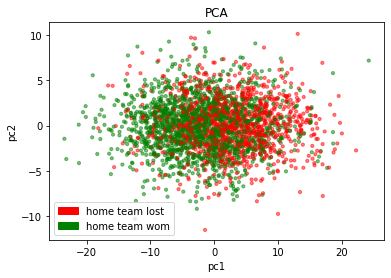

LDA (win vs loose)


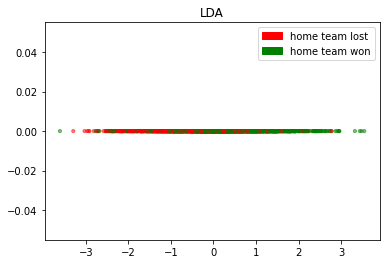

In [31]:
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA



colors = np.array(["red","green"])
#perform PCA
pcamodel = PCA(n_components=2)
PCA_train = pcamodel.fit_transform(X_train)
PCA_test = pcamodel.transform(X_test)
Y_test = Y_test.astype(int)

plt.title("PCA")
plt.xlabel("pc1")
plt.ylabel("pc2")
plt.scatter(PCA_test[:, 0], PCA_test[:, 1], s = 10, c = colors[Y_test], alpha=0.5)
win = mpatches.Patch(color='red', label='home team lost')
loose = mpatches.Patch(color='green', label='home team won')
plt.legend(handles=[win,loose])
print("PCA (win vs loose)")
plt.show()


# perform LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

ldamodel = LDA(n_components=1)
lda_train = ldamodel.fit_transform(X_train, Y_train )
lda_test = ldamodel.transform(X_test)

plt.title("LDA")
plt.scatter(lda_test, np.zeros(len(lda_test)), s = 10, c = colors[Y_test], alpha=0.5)
win = mpatches.Patch(color='red', label='home team lost')
loose = mpatches.Patch(color='green', label='home team won')
plt.legend(handles=[win,loose])
print("LDA (win vs loose)")
plt.show()



LG Accuracy:  0.6583829191459573
SVG Accuracy:  0.64053202660133
NB Accuracy:  0.6538326916345817


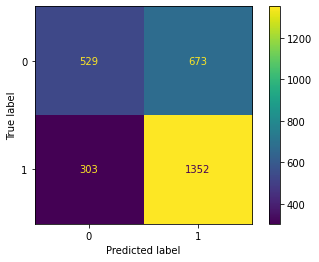

PCA LG Accuracy:  0.6587329366468323
PCA SVG Accuracy:  0.6443822191109555
PCA NB Accuracy:  0.656632831641582
LDA LG Accuracy:  0.6583829191459573
LDA SVG Accuracy:  0.6531326566328316
LDA NB Accuracy:  0.6587329366468323


In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB 

#on raw features
logisticRegr = LogisticRegression(solver='lbfgs', max_iter=12045)
logisticRegr.fit(X_train,Y_train)
score= logisticRegr.score(X_test,Y_test )
print("LG Accuracy: ",  str(score) )

svmModel = make_pipeline(StandardScaler(),SGDClassifier(max_iter=1000, tol=1e-3))
svmModel.fit(X_train, Y_train)
score= svmModel.score(X_test,Y_test )
print("SVG Accuracy: ",  str(score) )

NBmodel = GaussianNB()
NBmodel.fit(X_train, Y_train)
score= NBmodel.score(X_test,Y_test )
print("NB Accuracy: ",  str(score) )
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
predictions = logisticRegr.predict(X_test)
cm = confusion_matrix(Y_test, predictions, labels=logisticRegr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()
#on PCA

logisticRegr = LogisticRegression(solver='lbfgs', max_iter=12045)
logisticRegr.fit(PCA_train,Y_train)
score= logisticRegr.score(PCA_test,Y_test )
print("PCA LG Accuracy: ",  str(score) )



svmModel = make_pipeline(StandardScaler(),SGDClassifier(max_iter=1000, tol=1e-3))
svmModel.fit(PCA_train, Y_train)
score= svmModel.score(PCA_test,Y_test )
print("PCA SVG Accuracy: ",  str(score) )

NBmodel = GaussianNB()
NBmodel.fit(PCA_train, Y_train)
score= NBmodel.score(PCA_test,Y_test )
print("PCA NB Accuracy: ",  str(score) )

#on LDA
logisticRegr = LogisticRegression(solver='lbfgs', max_iter=12045)
logisticRegr.fit(lda_train,Y_train)
score= logisticRegr.score(lda_test,Y_test )
print("LDA LG Accuracy: ",  str(score) )

svmModel = make_pipeline(StandardScaler(),SGDClassifier(max_iter=1000, tol=1e-3))
svmModel.fit(lda_train, Y_train)
score= svmModel.score(lda_test,Y_test )
print("LDA SVG Accuracy: ",  str(score) )

NBmodel = GaussianNB()
NBmodel.fit(lda_train, Y_train)
score= NBmodel.score(lda_test,Y_test )
print("LDA NB Accuracy: ",  str(score) )

